In [47]:
import requests

url = 'https://fbref.com/en/comps/9/stats/Premier-League-Stats'

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9",
}

response = requests.get(url, headers=headers)

with open("fbref_page.html", "w", encoding="utf-8") as file:
    file.write(response.text)

# This is extracting the raw html from the page into a local HTML file


In [48]:
# Path to your saved HTML file
html_file = "fbref_page.html"

# Read the HTML file
with open(html_file, "r", encoding="utf-8") as file:
    lines = file.readlines()

# Specify the line you want to delete (e.g., line number 10)
line_to_delete = 902

# Remove the specified line
if 0 <= line_to_delete < len(lines):
    del lines[line_to_delete]

# Write the modified content back to the HTML file
with open(html_file, "w", encoding="utf-8") as file:
    file.writelines(lines)

print(f"Line {line_to_delete + 1} has been deleted from {html_file}.")

Line 903 has been deleted from fbref_page.html.


This was generated by ChatGPT, this allows me to remove the line of code from the HTML file that is stopping me from reading in the table that needs to be read in to the CSV file so that I can build my model

In [49]:
from bs4 import BeautifulSoup
import pandas as pd

# Path to your saved HTML file
html_file = "fbref_page.html"

# Load the HTML file with BeautifulSoup
with open(html_file, "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "lxml")  # You can also try 'lxml' if needed

# Locate the <table> with id 'stats_standard'
table = soup.find("table", {"id": "stats_standard"})

if table:
    print("Found <table id='stats_standard'>.")
    # Print the first 500 characters of the table for inspection
    print("Preview of <table> content:\n", table.prettify()[:500])

    # Parse the table using pandas
    try:
        df = pd.read_html(str(table))[0]
        # Save the DataFrame to a CSV file
        df.to_csv("prem_player_stats.csv", index=False)
        print("Player stats saved to 'prem_player_stats.csv'")
    except ValueError as e:
        print(f"Error parsing the table: {e}")
else:
    print("No <table> with id 'stats_standard' found.")

# This code was obtained from ChatGPT and it is used to extract tables from HTML files using BeautifulSoup and pandas.


Found <table id='stats_standard'>.
Preview of <table> content:
 <table class="min_width sortable stats_table min_width shade_zero" data-cols-to-freeze=",2" data-non-qual="1" data-qual-label="Hide non-qualifiers for rate stats" data-qual-text="" id="stats_standard">
 <caption>
  Player Standard Stats
  <span style="color: #666; font-size:smaller">
   2024-2025 Premier League
  </span>
  Table
 </caption>
 <colgroup>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
 
Player stats saved to 'prem_player_stats.csv'


/var/folders/jp/fbwfkpy50vs_7m6dlkzl468h0000gn/T/ipykernel_3890/2486324339.py:21: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


# Explanation Of Code

I had a lot of difficulty extracting this table from the initial code that was on the site, my original plan was to take it directly from the site but my code couldn't pick up the table that I needed to extract for my statistics. So then I tried extracting it to a local HTML file and this is where I started to find out more. I then began trying to extract my desired table from the HTML file that I had created but once again this was unable to pick up the table that I needed, I began reading through the raw HTML code of the site near where my desired table was when I eventually spotted this sign '<--' 2 lines above the table. This got me wondering as I recognised it as a comment symbol and I googled it and realised that comments aren't picked up in the search method I was using so I deleted this line in the local HTML file and ran my code again and the data extracted into my CSV so that I can pre proccess it and begin to build my model.

In [50]:
import sklearn
import pandas as pd

df = pd.read_csv("prem_player_stats.csv", header=1)
df.to_csv("prem_player_stats.csv", index=False)

# For the example I am going to do I am going to just use attackers

fw_df = df[df['Pos'].str.startswith("FW", na=False)] # I am doing this as some players have multiple positions but their main one is always listed first so I can just use the first two characters to filter

fw_df.to_csv("prem_fw_stats.csv", index=False)
fw_df = pd.read_csv("prem_fw_stats.csv")

This code block is just handling all of my imports for this model and then extracting all the forwards data from my playerbase csv so that I can begin to build my model from this data

In [51]:
filtered_data = fw_df.drop(['Rk', 'Nation', 'Pos', 'Squad', 'Age', 'Born', 'Matches'], axis=1)
filtered_data.to_csv("prem_fw_stats_filtered.csv", index=False)

I am now running into the issue with this data as I'm really not sure as to what my target value in this data is, I would ideally like to create a new field to be the target field but I'm not sure as to what formula I could use to calculate something that would act as a player score as such, I am currently researching the concept of pairwise comparison as I believe that might be useful

In [52]:
df = pd.read_csv("prem_fw_stats_filtered.csv")
df['Predicted_Goals'] = (df['Gls'] / df['MP'] * 38).round()
df['Over_15'] = (df['Predicted_Goals'] > 15).astype(int) # I learned about vectorised operations from this article: https://pythonspeed.com/articles/pandas-vectorization/
df.to_csv("prem_fw_stats_filtered.csv", index=False)


I have decided to build a model that can predict whether an attacker is going to score above or below 15 goals in a season. To do this I created a predicted goals for the season by taking the players current goals (As of 25/11/24) and dividing it by their matches played and then multiplying this by 38 as this is the total amount of games in a season. I then created a binary field for if they had over or under 15 goals as binary trees classification models work best with a binary result.

In [53]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df = pd.read_csv("prem_fw_stats_filtered.csv")

This is where I am getting the imports for the new model that I want to build as it will be a decision tree model

In [54]:
X = df[['Gls.1', 'xG.1', 'npxG.1']]
Y = df['Over_15']


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=258)

In this code block I am assigning the values that I have chosen to build my model from, I have chosen these specific values as I feel like they are going to helpful as they are Goals, Expected Goals & non penalty goals Per 90. Per 90 stats are good indicators as they take into account that players can go into streaks of scoring but then have quiet patches too where as normal stats just give you the overall numbers which sometimes can be misleading.

The last line is using Sci-Kit Learn's train test split package so that I can accurately train my data seperately from my test data. I have went for an 80% training set and 20% of test data.

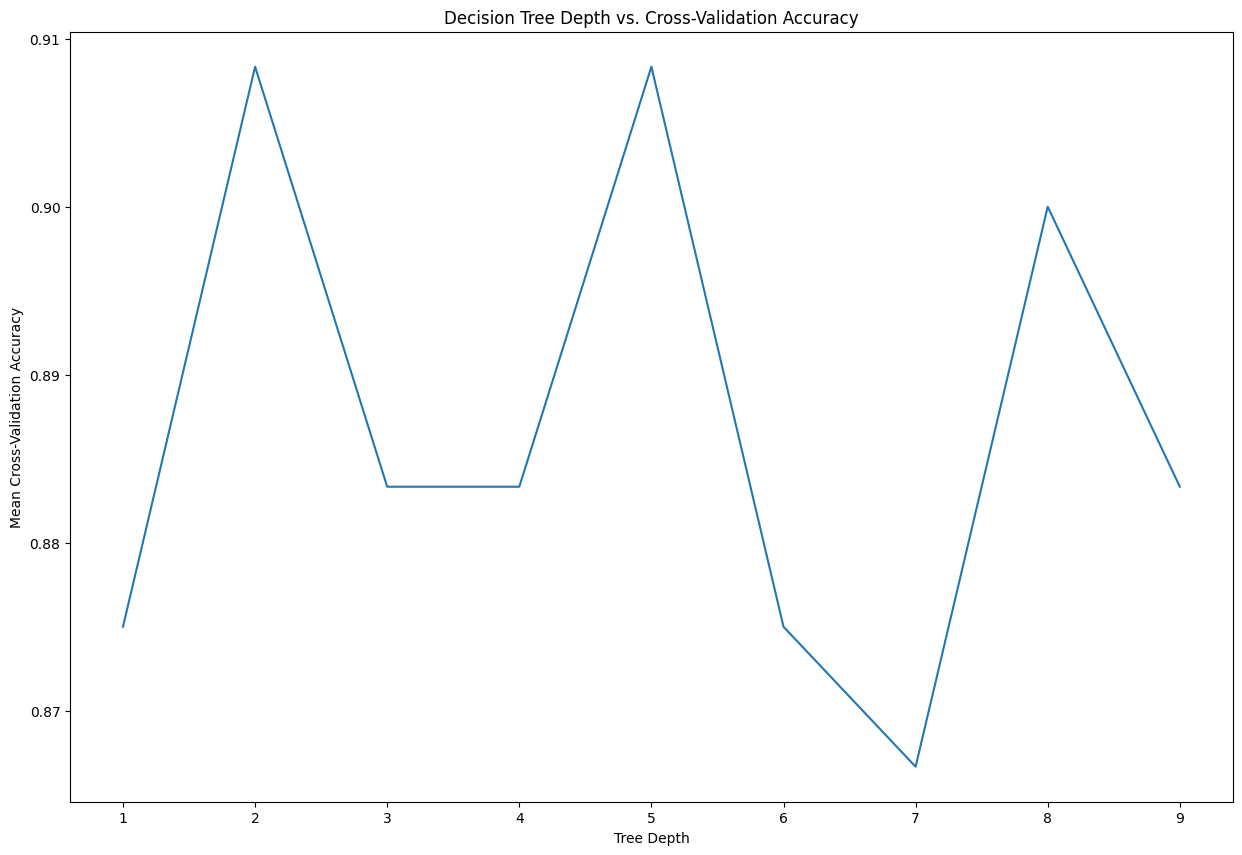

In [55]:
# Define a range of depths to evaluate
depths = range(1, 10)  # Test depths from 1 to 20
mean_scores = []

# Evaluate each depth using cross-validation
for depth in depths:
    decision_tree = DecisionTreeClassifier(max_depth=depth)
    scores = cross_val_score(decision_tree, X, Y, cv=5, scoring='accuracy')  # 5-fold cross-validation
    mean_scores.append(scores.mean())  # Store the mean accuracy for each depth

# Plot the results
plt.figure(figsize=(15, 10))
plt.plot(depths, mean_scores)
plt.xlabel('Tree Depth')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Decision Tree Depth vs. Cross-Validation Accuracy')
plt.show()

I got the above graph from ChatGPT. The function of this graph is to illustrate what depth of graph will give me the best accuracy for this model and as can be seen on the graph it is 6 nodes deep. This is helpful as it means I don't have to keep re running my model at different depths so that I can individually test the accuracy of each one

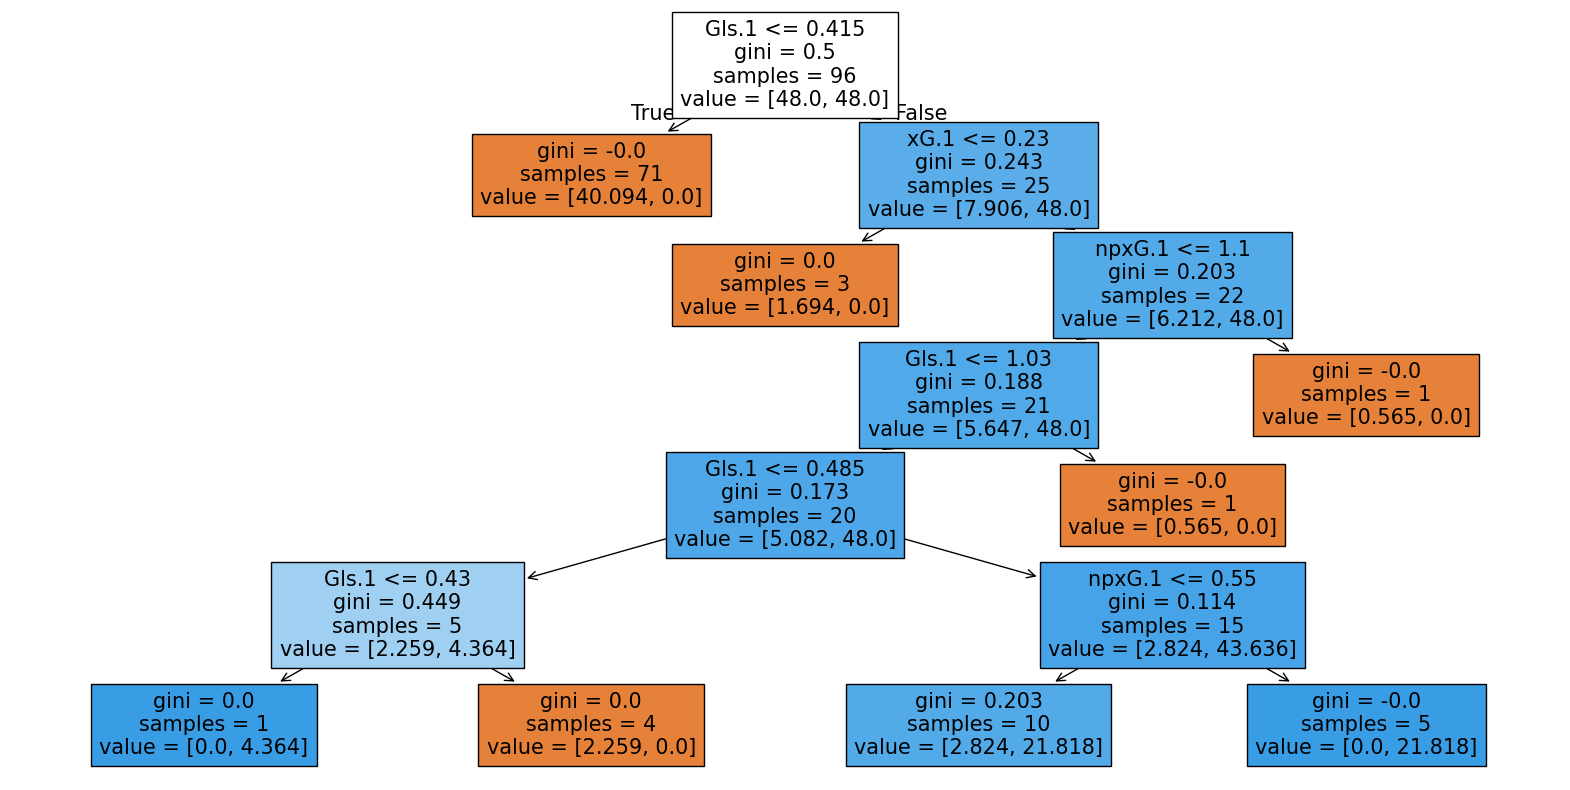

In [56]:
decision_tree = DecisionTreeClassifier(max_depth=6, class_weight="balanced") # I obtained class_weight="balanced" from ChatGPT and it's used to handle the imbalanced dataset
decision_tree = decision_tree.fit(x_train, y_train)

plt.figure(figsize=(20, 10)) # This line is used to set the size of the decision tree plot to make it more visible and readable
tree.plot_tree(decision_tree, feature_names=['Gls.1', 'xG.1', 'npxG.1'], filled=True)
plt.show()

This is a visual representation of the decision tree that the model is working off of and what it is checking for on each node level

In [57]:
decision_tree.fit(x_train, y_train)

predictions = decision_tree.predict(x_test)

accuracy = accuracy_score(y_test, predictions)
accuracy_percentage = accuracy * 100  

print('The accuracy of the decision tree model is: ', accuracy_percentage, '%')

The accuracy of the decision tree model is:  95.83333333333334 %


In this block, I am now using the test data which I seperated from the training data earlier to now get how accurate the model is, this works by getting all the correct results and dividing that by the wrong results, I am using SciKit-Learns accuracy score to figure this out. It is currently getting a score of around 96% which is very good for a model which a small dataset like the one that I am using.

In [64]:
# Example new sample data
example_prediction = pd.DataFrame({'Gls.1': [.49], 'xG.1': [.99], 'npxG.1': [.39]}) # I obtained this line from ChatGPT and it's used to create new sample data for a prediction

# Make a prediction
prediction = decision_tree.predict(example_prediction)
if prediction == 1:
    print("The player is predicted to score over 15 goals.")
else:
    print("The player is predicted to score under 15 goals.")

The player is predicted to score over 15 goals.
